<a href="https://colab.research.google.com/github/Matasnet/Wybory-2025-Symulacja/blob/main/Wybory2025_SymMonteCarlo.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Wybory 2025 w symulacji Monte Carlo  
  
W celu użycia symulacji należy zaimportować plik CSV o nazwie wybory.csv.  
Wykorzystuje on sondaże ze strony  
https://ewybory.eu/wybory-prezydenckie-2025-polska/sondaze-prezydenckie/  



## Import bibliotek

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats
import json

## Wczytywanie danych

In [2]:
# Wczytaj dane
df = pd.read_csv('Wybory.csv')

# Zamień '—' na NaN i przekonwertuj na liczby
df = df.replace('—', np.nan)
for col in df.columns[1:]:
    df[col] = pd.to_numeric(df[col], errors='coerce')

# Wyświetl pierwsze wiersze danych
df.head()

,Date,Zandberg,Biejat,Trzaskowski,Holownia,Nawrocki,Jakubiak,Mentzen,Braun
0,07.03.2025,2.0,3.0,37.0,8.0,21.0,1.0,22.0,3.0
1,03.03.2025,3.0,2.0,35.0,5.0,23.0,1.0,21.0,2.0
2,26.02.2025,2.6,1.8,33.6,7.9,16.5,2.2,18.9,2.9
3,24.02.2025,1.4,3.0,33.7,7.2,24.7,1.8,16.8,NaN
4,24.02.2025,1.0,4.4,34.1,7.1,25.7,2.7,16.2,0.6


## Przygotowanie symulacji

In [3]:
def run_single_simulation(data):
    results = []
    for candidate in data.columns[1:]:
        mean = data[candidate].mean()
        std = data[candidate].std()

        if pd.isna(mean) or pd.isna(std) or std == 0:
            mean = data[candidate].dropna().iloc[-1] if not data[candidate].dropna().empty else 0
            std = 2

        result = np.random.normal(mean, std)
        result = max(0, result)
        results.append(result)

    results = np.array(results)
    results = results / np.sum(results) * 100

    # Sprawdź, czy doszło do drugiej tury (czy żaden kandydat nie ma >50%)
    has_second_round = np.max(results) <= 50

    return results, has_second_round

## Przeprowadzeni symulacji

In [5]:
# Liczba symulacji
n_simulations = 30000

# Przeprowadź symulacje
simulation_results = []
second_round_count = 0  # Licznik symulacji z drugą turą

for _ in range(n_simulations):
    results, has_second_round = run_single_simulation(df)
    simulation_results.append(results)
    if has_second_round:
        second_round_count += 1

# Przekonwertuj wyniki na DataFrame
simulation_df = pd.DataFrame(simulation_results, columns=df.columns[1:])

# Oblicz prawdopodobieństwo drugiej tury
second_round_probability = (second_round_count / n_simulations) * 100
print(f"\nPrawdopodobieństwo drugiej tury: {second_round_probability:.2f}%")


Prawdopodobieństwo drugiej tury: 99.81%


## Analiza statystyczna oraz wizualna


Statystyki symulacji Monte Carlo (30000 symulacji)

Przewidywane wyniki (przedział 95% pewności):

Zandberg:
Średni wynik: 1.8%
Przedział 95% pewności: 0.3% - 3.4%
Odchylenie standardowe: 0.8%

Biejat:
Średni wynik: 3.9%
Przedział 95% pewności: 1.0% - 6.8%
Odchylenie standardowe: 1.4%

Trzaskowski:
Średni wynik: 39.7%
Przedział 95% pewności: 33.8% - 46.1%
Odchylenie standardowe: 3.2%

Holownia:
Średni wynik: 8.5%
Przedział 95% pewności: 4.9% - 12.0%
Odchylenie standardowe: 1.8%

Nawrocki:
Średni wynik: 27.2%
Przedział 95% pewności: 20.0% - 34.2%
Odchylenie standardowe: 3.6%

Jakubiak:
Średni wynik: 1.8%
Przedział 95% pewności: 0.2% - 3.4%
Odchylenie standardowe: 0.8%

Mentzen:
Średni wynik: 14.7%
Przedział 95% pewności: 7.8% - 21.1%
Odchylenie standardowe: 3.4%

Braun:
Średni wynik: 2.5%
Przedział 95% pewności: 0.6% - 4.4%
Odchylenie standardowe: 1.0%

Prawdopodobieństwo zwycięstwa:
Trzaskowski: 98.8%
Nawrocki: 1.2%


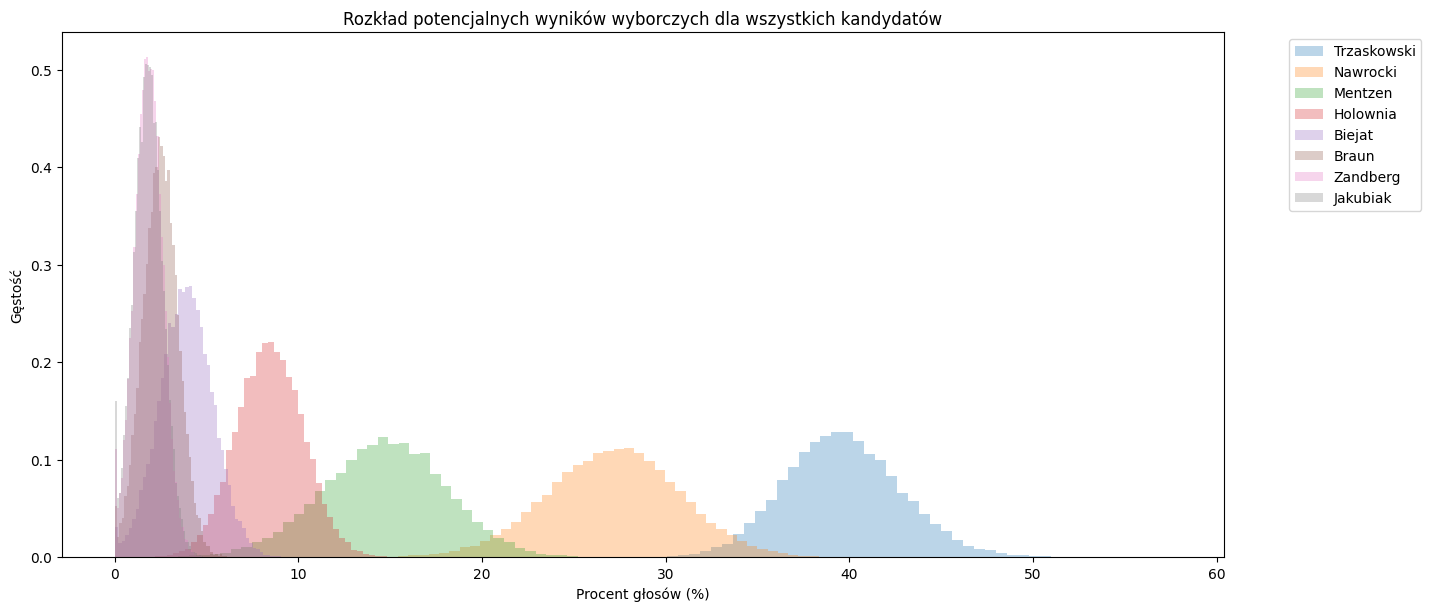

In [6]:
# Utwórz wykresy
plt.figure(figsize=(15, 15))

# Oblicz średnie dla każdego kandydata i posortuj
mean_results = simulation_df.mean().sort_values(ascending=False)

# 1. Rozkład wyników dla wszystkich kandydatów
plt.subplot(2, 1, 1)
for candidate in mean_results.index:  # Użyj posortowanych kandydatów
    plt.hist(simulation_df[candidate], bins=50, alpha=0.3, label=candidate, density=True)
plt.title('Rozkład potencjalnych wyników wyborczych dla wszystkich kandydatów')
plt.xlabel('Procent głosów (%)')
plt.ylabel('Gęstość')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')

# Wydrukuj statystyki
print(f"\nStatystyki symulacji Monte Carlo ({n_simulations} symulacji)")
print("=" * 70)
print("\nPrzewidywane wyniki (przedział 95% pewności):")
for candidate in df.columns[1:]:
    mean = simulation_df[candidate].mean()
    std = simulation_df[candidate].std()
    ci_lower = np.percentile(simulation_df[candidate], 2.5)
    ci_upper = np.percentile(simulation_df[candidate], 97.5)
    print(f"\n{candidate}:")
    print(f"Średni wynik: {mean:.1f}%")
    print(f"Przedział 95% pewności: {ci_lower:.1f}% - {ci_upper:.1f}%")
    print(f"Odchylenie standardowe: {std:.1f}%")

# Prawdopodobieństwo wygranej
winners = simulation_df.idxmax(axis=1)
win_probabilities = (winners.value_counts() / n_simulations * 100).round(2)
print("\nPrawdopodobieństwo zwycięstwa:")
for candidate, prob in win_probabilities.items():
    print(f"{candidate}: {prob:.1f}%")

plt.show()